## Using Google Earth 

In [1]:
import ee 
import folium
import geehydro
from datetime import datetime as dt
from IPython.display import Image

import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [135]:
############# User Input ##############
reservoir_name='Bivins Lake'
inp_start_date='2018-01-15'
inp_end_date='2019-01-01'
unique_str=reservoir_name+'_'+inp_start_date+'_'+inp_end_date

############# Reading Reservoir shapefiles and boundary polygons ###########

# Filepath to Unmonitored Reservoirs polygon KML file
res_poly_file = "C:\Sanchit\SW\My Places.kml"

# Filepath to Major Reservoirs shapefile
res_shp_file = "C:\\Sanchit\\SW\\Reservoir Shapefiles\\2017_SWP_Major_Existing_Reservoirs.shp"

# Reading shapefile and verify if reservoir data is there
poly_reservoirs=gpd.read_file(res_shp_file)
if (~(poly_reservoirs['RES_LBL'].str.contains(reservoir_name).any())):
    # Reading data from kml file if reservoir data is not in shp file
    poly_reservoirs=gpd.read_file(res_poly_file, driver='KML')

# Calculating reservoir centeroid for lat-lon
poly_reservoirs['Center_point'] = poly_reservoirs['geometry'].to_crs('+proj=cea').centroid.to_crs(
                                                                            poly_reservoirs['geometry'].crs)

# Extracting reservoir information 
reservoir_data=poly_reservoirs[poly_reservoirs['Name']==reservoir_name].reset_index(drop=True)
res_lat=reservoir_data['Center_point'].y[0]
res_lon=reservoir_data['Center_point'].x[0]
res_bbox=reservoir_data['geometry'].bounds

In [27]:
# initialize the connection to the server
ee.Initialize()

In [4]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
        if ee.image.Image in [type(x) for x in v.values()]:
            folium.TileLayer(
                tiles = v["tile_fetcher"].url_format,
                attr  = 'Google Earth Engine',
                overlay =True,
                name  = k
              ).add_to(mapViz)
        else:
            folium.GeoJson(
            data = v,
            name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [5]:
def poly2feature(polygon):
    x,y = polygon.exterior.coords.xy
    cords = np.dstack((x,y)).tolist()

    g=ee.Geometry.Polygon(cords)#.buffer(500) in meters
    feature = ee.Feature(g)
    return feature

In [6]:
# Function to convert feature collection to dictionary.
def fc_2_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
    reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [117]:
clipping_feature=poly2feature(reservoir_data.geometry[0])
# setting the Area of Interest (AOI)
Reservoir_AOI = ee.Geometry.Rectangle(res_bbox.values.reshape(-1).tolist())

In [8]:
# Prepares a mosaic using image collection of one day
def day_mosaic(date,imcol,satellite):
    d = ee.Date(date)
    img=imcol.first()
    
    im = imcol.filterDate(d, d.advance(1, "day")).mosaic()
    
    if(satellite=='landsat-08'):
        sun_azimuth=img.get('SUN_AZIMUTH')
        sun_altitude=img.get('SUN_ELEVATION')
    elif(satellite=='sentinel-2'):
        sun_azimuth=img.get('MEAN_SOLAR_AZIMUTH_ANGLE')
        sun_altitude=ee.Number(90).subtract(img.get('MEAN_SOLAR_ZENITH_ANGLE'))
    else:
        return im.set("system:time_start", d.millis(),"DATE_ACQUIRED", d.format("YYYY-MM-dd"))
    
    return im.set("system:time_start", d.millis(),"DATE_ACQUIRED", d.format("YYYY-MM-dd"),
                  "SUN_AZIMUTH",sun_azimuth,"SUN_ALTITUDE",sun_altitude)

# Prepares an image collection of mosaics by date
def mosaicByDate(imcol,satellite):
    # imcol: An image collection
    # returns: An image collection
    
    # Converting collection to list
    imlist = imcol.toList(imcol.size())
    
    # Extracting unique dates in the collection  
    unique_dates = imlist.map(lambda image: ee.Image(image).date().format("YYYY-MM-dd")).distinct()
    
    mosaic_imlist = unique_dates.map(lambda date: day_mosaic(date,imcol,satellite))

    return ee.ImageCollection(mosaic_imlist)

## Sentinel 1 - Using Google Earth Engine

In [121]:
# Filters speckle noise
def Specklefilter(image):
    vv = image.select('VV') #select the VV polarization band
    vv_smoothed = vv.focal_median(30,'square','meters').rename('VV_Filtered') #Apply a focal median filter
    return image.addBands(vv_smoothed) #Add filtered VV band to original image

# Reservoir Water area calculation for sentinel-1 data
def sentinel1_water_area_calculation_in_image(inp_image,clip_feature=None,image_return=False):
    # Speckle filter 
    pro_image=Specklefilter(inp_image)
    # clipping image if required
    if(clip_feature):
        pro_image=pro_image.clip(clipping_feature)
    pro_image=pro_image.select('VV_Filtered')
    # Removing land pixels based on VV>=-13 dB
    water_classified=pro_image.lt(-13)
    
    # Returning image if yes
    if(image_return):
        return pro_image.where(water_classified.eq(1),1).where(water_classified.eq(0),0)
    
    # Counting total pixels, water pixels and calculating area
    # Total pixels    
    total_pixels=ee.Number(pro_image.reduceRegion(reducer=ee.Reducer.count(),
                                                          geometry=clipping_feature.geometry(),scale=10).get('VV_Filtered'))
    # Water pixels
    pro_image=pro_image.updateMask(water_classified)
    water_pixels=ee.Number(pro_image.reduceRegion(reducer=ee.Reducer.count(),
                                                          geometry=clipping_feature.geometry(),scale=10).get('VV_Filtered'))
    return ee.Feature(None,{'Satellite':'Sentinel-1',
                            'Product': 'S1_GRD',
                            'Date':inp_image.get('DATE_ACQUIRED'),
                            'Water Area':water_pixels.multiply(10).multiply(10).divide(1000000),
                            'Total Area':total_pixels.multiply(10).multiply(10).divide(1000000),
                             'Cloud Percent Area': ee.Number(0)})

In [122]:
# filter area and dates
sentinel_1_AOI = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(Reservoir_AOI).filterDate(inp_start_date, inp_end_date)
# make a mosaic if needed
sentinel_1_AOI_mosaic=mosaicByDate(sentinel_1_AOI,'sentinel-1')
# water area calculation
sentinel_1_water_area_collection=sentinel_1_AOI_mosaic.map(lambda image: sentinel1_water_area_calculation_in_image(image,clipping_feature))

In [123]:
sentinel_1_water_area_collection.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0',
 'properties': {'Cloud Percent Area': 0,
  'Date': '2018-01-25',
  'Product': 'S1_GRD',
  'Satellite': 'Sentinel-1',
  'Total Area': 0.9598,
  'Water Area': 0.5903}}

#### Visualising

In [124]:
image=sentinel_1_AOI_mosaic.first()
image=sentinel1_water_area_calculation_in_image(image,clipping_feature,True)

Id = image.getMapId({'palette': ['green','blue'], 'min': 0, 'max': 1})

tiles = {"Reservoir": Id}
center = [res_lat, res_lon]
Mapdisplay(center, tiles,zoom_start=14)

## Sentinel 2 - Using Google Earth Engine 

In [130]:
# Having a uniform resolution in sentinel image
def sentinel2_refineresolution(image,band,scale):
    band_img=image.select(band)
    image=image.resample('bilinear').reproject(**{
      'crs': band_img.projection().crs(),
      'scale': scale
        });
    return image

# Renaming bands 
def renameBands_sentinel2(x,product):
    if(product=='S2_SR'):
        bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'QA60']
    new_bands = ['B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'qa_pixel']
    return x.select(bands).rename(new_bands)

# Transforming Sentinel-2 to Landsat-8
def sentinel2_to_landsat8(image,product):
    image=renameBands_sentinel2(image,product)
    # Linear transformations
    landsat_b=image.select('B').multiply(0.9570).add(0.0003).rename('L_B')
    landsat_g=image.select('G').multiply(1.0304).add(0.0015).rename('L_G')
    landsat_r=image.select('R').multiply(0.9533).add(0.0041).rename('L_R')
    landsat_nir=image.select('NIR').multiply(1.0157).add(0.0139).rename('L_NIR')
    landsat_swir1=image.select('SWIR1').multiply(0.9522).add(0.0034).rename('L_SWIR1')
    landsat_swir2=image.select('SWIR2').multiply(0.9711).add(0.0004).rename('L_SWIR2')
    return image.addBands([landsat_b,landsat_g,landsat_r,landsat_nir,landsat_swir1,landsat_swir2])
    
# Water area calculation in sentinel-2 image
def sentinel2_water_area_calculation_in_image(inp_image,method,clip_feature=None,product='S2_SR',image_return=False):
    # Clipping image
    if(clip_feature):
        pro_image=inp_image.clip(clipping_feature)
    else:
        pro_image=inp_image
    
    # Sentinel2 to Landsat8
    pro_image = sentinel2_to_landsat8(pro_image,product)
    
    # Calculating method
    if(method=='NDWI'):
        pro_image=ndwi(pro_image,product)
        # Removing land pixels based on ndwi<=0
        water_classified=pro_image.select('NDWI').gt(0)
        cloud_classified=pro_image.select('cloud_mask').eq(1)
    elif(method=='MNDWI'):
        pro_image=mndwi(pro_image,product)
        # Removing land pixels based on mndwi<=0
        water_classified=pro_image.select('MNDWI').gt(0)
        cloud_classified=pro_image.select('cloud_mask').eq(1)
    elif(method=='DSWE'):
        pro_image=dswe(pro_image,product)
        # Removing land pixels based on dswe=0 & 9
        water_classified=pro_image.gt(0).add(pro_image.lte(4)).eq(2)
        cloud_classified=pro_image.eq(9)
    
    # Returning water image if yes
    if(image_return):
        if(method=='DSWE'):
            return pro_image.where(water_classified.eq(1),1).where(water_classified.eq(0),0).updateMask(pro_image.neq(9))
        else:
            return pro_image.select(method).where(water_classified.eq(1),1).where(water_classified.eq(0),0).updateMask(
                                                                                    pro_image.select('cloud_mask').neq(1))
    # Total pixels    
    total_pixels=ee.Number(pro_image.select(method).reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=10).get(method))
    # Counting cloud pixels 
    cloud_image=pro_image.select(method).updateMask(cloud_classified)
    cloud_pixels=ee.Number(cloud_image.reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=10).get(method))
    
    # Counting water pixels and calculating area
    water_image=pro_image.select(method).updateMask(water_classified)
    water_pixels=ee.Number(water_image.reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=10).get(method))
    
    return ee.Feature(None,{'Satellite':'Sentinel-2_'+method,
                            'Date':inp_image.get('DATE_ACQUIRED'),
                            'Water Area':water_pixels.multiply(10).multiply(10).divide(1000000),
                            'Cloud Percent Area':cloud_pixels.divide(total_pixels).multiply(100),
                            'Total Area':total_pixels.multiply(10).multiply(10).divide(1000000)})

In [125]:
# filter area and dates
sentinel_2_AOI = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(Reservoir_AOI)#.filterDate(inp_start_date, inp_end_date)
#Refining resolution
sentinel_2_AOI = sentinel_2_AOI.map(lambda image : sentinel2_refineresolution(image, 'B2', 10))
# make a mosaic if needed
sentinel_2_AOI_mosaic=mosaicByDate(sentinel_2_AOI,'sentinel-2')
# water area calculation
sentinel2_water_area_collection=sentinel_2_AOI_mosaic.map(lambda image: sentinel2_water_area_calculation_in_image(image,'DSWE',clipping_feature))

In [126]:
sentinel2_water_area_collection.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0',
 'properties': {'Cloud Percent Area': 0,
  'Date': '2018-12-13',
  'Satellite': 'Sentinel-2_DSWE',
  'Total Area': 0.9598,
  'Water Area': 0.1651}}

In [129]:
image= sentinel2_water_area_calculation_in_image(sentinel_2_AOI_mosaic.first(),'NDWI',clipping_feature,image_return=True)
Id = image.getMapId({'palette': ['green','blue'], 'min': 0, 'max': 1})

tiles = {"Reservoir": Id}
center = [res_lat, res_lon]
Mapdisplay(center, tiles,zoom_start=14)

## Landsat - Using Google Earth Engine

In [44]:
def renameBands_Landsat8(x,product):
    if(product=='SR'):
        bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']
    elif(product=='TOA'):
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'BQA']
    elif(product=='S2_SR'):
        bands = ['L_B', 'L_G', 'L_R', 'L_NIR', 'L_SWIR1', 'L_SWIR2', 'qa_pixel']
    new_bands = ['B', 'G', 'R', 'NIR', 'SWIR1', 'SWIR2', 'qa_pixel']
    return x.select(bands).rename(new_bands)

def createCloudAndShadowBand(x,product):
    qa = x.select('qa_pixel');
    if(product=='SR'):
        cloudbitnumber=2**3+2**8+2**9
        cloudshadowbitnumber=2**4+2**10+2**11
    elif(product=='TOA'):
        cloudbitnumber=2**4+2**5+2**6
        cloudshadowbitnumber=2**7+2**8
    elif(product=='S2_SR'):
        cloudbitnumber=2**10
        cloudshadowbitnumber=2**11   #cirrus bit number, to keep similarity with TOA and SR products,it is named cloud shadow bit
    cloudBitMask = ee.Number(cloudbitnumber).int();
    cloudShadowBitMask = ee.Number(cloudshadowbitnumber).int();
    cloud = qa.bitwiseAnd(cloudBitMask).eq(cloudbitnumber);
    cloudShadow = qa.bitwiseAnd(cloudShadowBitMask).eq(cloudshadowbitnumber);
    mask = (ee.Image(0).where(cloud.eq(1), 1)
        .where(cloudShadow.eq(1), 1)
        .rename('cloud_mask'));
    return x.addBands(mask)

#################### DSWE Function #########################
def dswe(image,product):
    '''
    DSWE
    ====
    Apply DSWE algorithm to a single image
    Arguments:
    ----------
    image:  ee.Image object (must be Landsat-8 SR Collection-2 TR-1 product)
    product: 'SR','TOA' or 'S2_SR'
    '''
    # Reading a DEM
    dem=ee.Image('CGIAR/SRTM90_V4').select('elevation')
    
    # Add Hill shade
    sun_altitude=image.get('SUN_ALTITUDE')
    sun_azimuth=image.get('SUN_AZIMUTH')
    image=image.addBands(ee.Terrain.hillshade(dem,sun_azimuth,sun_altitude).rename('hillshade'))
    
    # Calculating slope
    slope=ee.Terrain.slope(dem).rename('slope')
    
    # Add cloud mask dnd rename bands
    img = createCloudAndShadowBand(renameBands_Landsat8(image,product),product)
    
    # Calculate indices
    indices = calc_indices(img)
    
    # Perform comparisons of various indices with thresholds and outputs the result of each test in a bit
    tests = addTests(indices)
    
    # Classify pixels into different classes to create interpreted dswe band
    dswe = ee.Image(-1) \
        .where(isDSWE0(tests), 0) \
        .where(isDSWE1(tests), 1) \
        .where(isDSWE2(tests), 2) \
        .where(isDSWE3(tests), 3) \
        .where(isDSWE4(tests), 4) \
        .where(isDSWE9(tests), 9) \
        .updateMask(img.select('qa_pixel').mask()) \
        .rename("DSWE") 
    
    # Classifying pixels having  hill shade less than equal to 110 as not water(0) 
    dswe=dswe.where(image.select('hillshade').lte(110),0)
    
    # Classifying pixels using interpreted DSWE and slope
    dswe=dswe.where((dswe.eq(4) and slope.gte(5.71)).Or                # 10% slope = 5.71°
                      (dswe.eq(3) and slope.gte(11.31)).Or           # 20% slope = 11.31°
                      (dswe.eq(2) and slope.gte(16.7)).Or            # 30% slope = 16.7°
                      (dswe.eq(1) and slope.gte(16.7)), 0);          # 30% slope = 16.7°

    return dswe

# INDICES
def calc_mndwi(image):
    mndwi = ee.Image(0).expression(
        '((g - swir1)/(g + swir1)) * 10000',
            {
                'g': image.select("G"),
                'swir1': image.select("SWIR1")
            })
    return mndwi.toInt16().rename("MNDWI")

def calc_mbsr(image):
    mbsr = ee.Image(0).expression(
        '(g + r) - (nir + swir1)',
        {
            'g': image.select("G"),
            'r': image.select("R"),
            'nir': image.select("NIR"),
            'swir1': image.select("SWIR1")
        })
    return mbsr.toInt16().rename("MBSR")

def calc_ndvi(image):
    ndvi = ee.Image(0).expression(
        '((nir - r)/(nir + r)) * 10000',
        {
          'nir': image.select("NIR"),
          'r': image.select("R")
        })
    return ndvi.toInt16().rename("NDVI")

def calc_awesh(image):
    awesh = ee.Image(0).expression(
        'blue + A*g - B*(nir+swir1) - C*swir2',
        {
            'blue': image.select('B'),
            'g': image.select('G'),
            'nir': image.select('NIR'),
            'swir1': image.select('SWIR1'),
            'swir2': image.select('SWIR2'),
            'A': 2.5,
            'B': 1.5,
            'C': 0.25
        })
    return awesh.toInt16().rename("AWESH")

# wrapper
def calc_indices(image):
    bands = ee.Image([
        calc_mndwi(image),
        calc_mbsr(image),
        calc_ndvi(image),
        calc_awesh(image),
        image.select("B"),
        image.select("NIR"),
        image.select("SWIR1"),
        image.select("SWIR2"),
        image.select("cloud_mask")
    ])
    return bands.set('system:time_start', image.get('system:time_start'))

# DSWE test functions
def test1(image):
    return image.select("MNDWI").gt(124)    ## wigt - default value 0.0124 * 10000

def test2(image):
    return image.select("MBSR").gt(0)      ## mbsrv>mbsrn -> mbsr=mbsrv-mbsrn>0

def test3(image):
    return image.select("AWESH").gt(0)    ## awgt - default value 0

def test4(image):
    x = (image.select("MNDWI").gt(-5000)       ## pswt_1_mndwi - default value -0.044 * 10000
        .add(image.select("SWIR1").lt(900))    ## pswt_1_swir1 - default value 900
        .add(image.select("NIR").lt(1500))     ## pswt_1_nir - default value 1500
        .add(image.select("NDVI").lt(7000))     ## pswt_1_ndvi - default value 0.7 * 10000
        )
    return x.eq(4)

def test5(image):
    x = (image.select("MNDWI").gt(-5000)         ## pswt_2_mndwi - default value -0.5 * 10000
        .add(image.select("B").lt(1000))        ## pswt_2_blue  - default value 1000
        .add(image.select("NIR").lt(2500))      ## pswt_2_nir   - default value 2500
        .add(image.select("SWIR1").lt(3000))    ## pswt_2_swir1 - default value 
        .add(image.select("SWIR2").lt(1000))
        )
    return x.eq(5)

def cloudTest(image):
    return image.select('cloud_mask').eq(1)

# wrapper/multiplier function
def addTests(image):
    x1 = test1(image)
    x2 = test2(image).multiply(10);
    x3 = test3(image).multiply(100);
    x4 = test4(image).multiply(1000);
    x5 = test5(image).multiply(10000);
    cld = cloudTest(image);
    res = x1.add(x2).add(x3).add(x4).add(x5).rename('test') \
        .where(cld.eq(1), -1) \
        .set('system:time_start', image.get('system:time_start'));
    return res

# DSWE CLASSES
def isDSWE0(image):
    y1 = image.lte(10).add(image.gte(0)).eq(2)
    y2 = image.eq(100).add(image.eq(1000)).eq(1)
    y = y1.add(y2).gt(0) \
        .rename("DSWE0") \
        .set('system:time_start', image.get('system:time_start'))
    return y

def isDSWE1(image):
    y1 = image.gte(11101).add(image.lte(11111)).eq(2)
    y2 = image.eq(1111).add(image.eq(10111)).add(image.eq(11011)).eq(1)
    y = y1.add(y2).gt(0) \
        .rename("DSWE1") \
        .set('system:time_start', image.get('system:time_start'))
    return y

def isDSWE2(image):
    y1 = image.eq(111).add(image.eq(1011)).add(image.eq(1101)).add(image.eq(1110)).add(image.eq(10011)) \
         .add(image.eq(10101)).add(image.eq(10110)).add(image.eq(11001)).add(image.eq(11010)).add(image.eq(11100)).eq(1)
    y = y1.gt(0) \
        .rename("DSWE2") \
        .set('system:time_start', image.get('system:time_start'))
    return y

def isDSWE3(image):
    y = image.eq(11000) \
        .rename("DSWE3") \
        .set('system:time_start', image.get('system:time_start'))
    return y
    
def isDSWE4(image):
    y1 = image.eq(11).add(image.eq(101)).add(image.eq(110)).add(image.eq(1001)).add(image.eq(1010)) \
         .add(image.eq(1100)).add(image.eq(10000)).add(image.eq(10001)).add(image.eq(10010)).add(image.eq(10100)).eq(1)
    y = y1.gt(0) \
        .rename("DSWE4") \
        .set('system:time_start', image.get('system:time_start'))
    return y

def isDSWE9(image):
    y = image.eq(-1) \
        .rename("DSWE9") \
        .set('system:time_start', image.get('system:time_start'))
    return y

########################### MNDWI Function ####################
def mndwi(image,product):
    if(product=='SR'):
        img = createCloudAndShadowBand(renameBands_Landsat8(image,product),product)
    elif(product=='S2_SR'):
        img = createCloudAndShadowBand(image,product)
    mndwi = img.normalizedDifference(['G', 'SWIR1']).rename("MNDWI")
    return mndwi.addBands(img.select('cloud_mask'))

########################## NDWI Function ####################
def ndwi(image,product):
    if(product=='SR'):
        img = createCloudAndShadowBand(renameBands_Landsat8(image,product),product)
    elif(product=='S2_SR'):
        img = createCloudAndShadowBand(image,product)
    ndwi = img.normalizedDifference(['G', 'NIR']).rename("NDWI")
    return ndwi.addBands(img.select('cloud_mask'))

In [45]:
def landsat_water_area_calculation_in_image(inp_image,method,clip_feature=None,product='SR',image_return=False):
    # Clipping image
    if(clip_feature):
        pro_image=inp_image.clip(clipping_feature)
    else:
        pro_image=inp_image
        
    # Calculating method
    if(method=='NDWI'):
        pro_image=ndwi(pro_image,product)
        # Removing land pixels based on ndwi<=-0.05
        water_classified=pro_image.select('NDWI').gt(0)
        cloud_classified=pro_image.select('cloud_mask').eq(1)
    elif(method=='MNDWI'):
        pro_image=mndwi(pro_image,product)
        # Removing land pixels based on mndwi<=0
        water_classified=pro_image.select('MNDWI').gt(0)
        cloud_classified=pro_image.select('cloud_mask').eq(1)
    elif(method=='DSWE'):
        pro_image=dswe(pro_image,product)
        # Removing land pixels based on dswe=0 & 9
        water_classified=pro_image.gt(0).add(pro_image.lte(4)).eq(2)
        cloud_classified=pro_image.eq(9)
    
    # Returning water image if yes
    if(image_return):
        if(method=='DSWE'):
            return pro_image.where(water_classified.eq(1),1).where(water_classified.eq(0),0).updateMask(pro_image.neq(9))
        else:
            return pro_image.select(method).where(water_classified.eq(1),1).where(water_classified.eq(0),0).updateMask(
                                                                                    pro_image.select('cloud_mask').neq(1))
    # Total pixels    
    total_pixels=ee.Number(pro_image.select(method).reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=30).get(method))
    
    # Counting cloud pixels 
    cloud_image=pro_image.select(method).updateMask(cloud_classified)
    cloud_pixels=ee.Number(cloud_image.reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=30).get(method))
    
    # Counting water pixels and calculating area
    water_image=pro_image.select(method).updateMask(water_classified)
    water_pixels=ee.Number(water_image.reduceRegion(reducer=ee.Reducer.count(),geometry=clipping_feature.geometry(),
                                                                      scale=30).get(method))
    
    return ee.Feature(None,{'Satellite':'Landsat-08_'+method,
                            'Date':inp_image.get('DATE_ACQUIRED'),
                            'Water Area':water_pixels.multiply(30).multiply(30).divide(1000000),
                            'Cloud Percent Area':cloud_pixels.divide(total_pixels).multiply(100),
                            'Total Area':total_pixels.multiply(30).multiply(30).divide(1000000)})

In [131]:
# filter area and dates
landsat_AOI = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(Reservoir_AOI).filterDate(inp_start_date,inp_end_date)
# make a mosaic if needed
landsat_AOI_mosaic = mosaicByDate(landsat_AOI,'landsat-08')
# water area calculation
landsat_water_area_collection=landsat_AOI_mosaic.map(lambda image: landsat_water_area_calculation_in_image(image,'DSWE',clipping_feature))

In [132]:
landsat_water_area_collection.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0',
 'properties': {'Cloud Percent Area': 0,
  'Date': '2018-01-17',
  'Satellite': 'Landsat-08_DSWE',
  'Total Area': 0.9531,
  'Water Area': 0.1485}}

In [383]:
# Export the FeatureCollection to a KML file.
task = ee.batch.Export.table.toDrive(**{
  'collection': landsat_water_area_collection,
  'description': unique_str,
  'fileFormat': 'CSV'
})
task.start()

while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(5)

#### Visualising Results

In [133]:
img=landsat_AOI_mosaic.first()#.clip(clipping_feature).normalizedDifference(['SR_B3','SR_B6'])
img=landsat_water_area_calculation_in_image(img,'NDWI',clipping_feature,image_return=True)
Id = img.getMapId({'palette': ['green','blue'], 'min': 0, 'max': 1})

tiles = {"Reservoir": Id}
center = [res_lat, res_lon]
Mapdisplay(center, tiles,zoom_start=14)

## Using Local Machine

In [26]:
from landsatxplore.earthexplorer import EarthExplorer
import tarfile
import json
from landsatxplore.api import API

import pandas as pd
import os
from glob import glob
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [20]:
def check_crs(raster_path):
    """
    Returns the CRS of a raster file.

    Parameters
    ----------
    raster_path : string
        A path to a raster file that you wish to check the crs of. Assuming
        this is a tif file.

    Returns
    -------
    A crs object

    """

    with rio.open(raster_path) as src:
        return src.crs


def open_clean_band(band_path, crop_layer=None, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    A single xarray object with the Landsat band data.

    """

    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band


def process_bands(paths, crop_layer=None, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).

    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.

    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("Data is getting stacked.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands
    

def water_area_landsat_scene_calculation(landsat_scene_folder,reservoir_data):
    """
    Returns the reservoir water area in a landsat scene.

    Parameters
    ----------
    landsat_scene_folder : string
        A path to a landsat scene folder that you want to use for calculating water area. Assuming
        this is a folder contatining landsat-08 tif files. This function uses only band5, 6 and QA.
    
    reservoir_data : geodataframe
        A geodataframe containing the reservoir geometry that you wish to crop your
        data to.

    Returns
    -------
    A float object  

    """
    # Generate a list of tif files
    tif_file_paths = glob(os.path.join(landsat_scene_folder,"*B[5-6,Qtif]*.tif"))
    tif_file_paths.sort()
    
    # Reproject polygon/shapefile data to CRS of landsat data
    landsat_crs=check_crs(tif_file_paths[0])
    crop_boundary_chng_crs = reservoir_data['geometry'].to_crs(landsat_crs)
    
    # Read band 5, 6 and cropping it to reservoir polygon
    landsat_raw_data = process_bands(tif_file_paths[:-1], crop_layer=crop_boundary_chng_crs,stack=True)
    
    # Read band QA and cropping it to reservoir polygon
    landsat_qa = open_clean_band(tif_file_paths[2],crop_boundary_chng_crs)

    # Getting pixel values to be masked for clouds in QA band
    high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

    all_masked_values = cloud_shadow + cloud + high_cloud_confidence

    # Mask the cloud pixel values and make them NAN in landsat image
    cloud_mask = landsat_qa.isin(all_masked_values)
    landsat_without_cloud = landsat_raw_data.where(~cloud_mask)
    
    # Calculate NDWI and label the pixels with value >0 as 1
    ndwi_landsat=(landsat_without_cloud[0]-landsat_without_cloud[1])/(landsat_without_cloud[0]+landsat_without_cloud[1])
    water_landsat=ndwi_landsat.where(~(ndwi_landsat.values>0),1)
    
    # Area calculation based on number of pixels with label 1
    return (len(water_landsat.values[water_landsat.values==1])*30*30)/(1000*1000)

In [9]:
############# User Input ##############
username= 'Enter your EarthExplorer username'
password='Enter your EarthExplorer password'
reservoir_name='Barney M Davis Reservoir'
inp_start_date='2018-01-01'
inp_end_date='2018-02-01'
unique_str=reservoir_name+'_'+inp_start_date+'_'+inp_end_date

############# Output Result ###########
dates=[]
water_area=[]

############# Reading Reservoir shapefiles and boundary polygons ###########

# Filepath to Unmonitored Reservoirs polygon KML file
res_poly_file = "C:\Sanchit\SW\My Places.kml"

# Filepath to Major Reservoirs shapefile
res_shp_file = "C:\\Sanchit\\SW\\Reservoir Shapefiles\\2017_SWP_Major_Existing_Reservoirs.shp"

# Reading shapefile and verify if reservoir data is there
poly_reservoirs=gpd.read_file(res_shp_file)
if (~(poly_reservoirs['RES_LBL'].str.contains(reservoir_name).any())):
    # Reading data from kml file if reservoir data is not in shp file
    poly_reservoirs=gpd.read_file(res_poly_file, driver='KML')

# Calculating reservoir centeroid for lat-lon
poly_reservoirs['Center_point'] = poly_reservoirs['geometry'].to_crs('+proj=cea').centroid.to_crs(
                                                                            poly_reservoirs['geometry'].crs)

# Extracting reservoir information 
reservoir_data=poly_reservoirs[poly_reservoirs['Name']==reservoir_name]
res_lat=reservoir_data['Center_point'].y[0]
res_lon=reservoir_data['Center_point'].x[0]
res_bbox=reservoir_data['geometry'].bounds

############# Searching Landsat Data for the selected reservoir ###############

# Initialize a new API instance and get an access key
api = API(username, password)

# Search for Landsat TM scenes
scenes = api.search(
    dataset='landsat_8_c1',
    latitude=res_lat,
    longitude=res_lon,
    bbox=res_bbox,
    start_date=inp_start_date,
    end_date=inp_end_date
)

print(f"{len(scenes)} scenes found.")

display_ids=[]
# Process the searched results and saving display_ids for further downloading

for scene in scenes:
    print(scene['acquisition_date'].strftime('%Y-%m-%d'))
    dates.append(scene['acquisition_date'].strftime('%Y-%m-%d'))
    display_ids.append(scene['display_id'])
    
api.logout()

############# Downloading and unzipping the searched Landsat scenes ############

ee = EarthExplorer(username, password)
for each_id in display_ids:
    print("Downloading data ......")
    ee.download(each_id, output_dir='./landsat_'+unique_str)
    open_tar = tarfile.open('./landsat_'+unique_str+'//'+each_id+'.tar.gz')
    open_tar.extractall('./landsat_'+unique_str+'//'+each_id) # specify which folder to extract to
    open_tar.close()
ee.logout()

############# Processing landsat data for each scene and estimating water area within resevoir boundary #########
for each_id in display_ids:
    # Path to landsat scene folder 
#     landsat_folder_path = './landsat_'+unique_str+'//'+each_id+'//'
    landsat_folder_path = './data//'+each_id+'//'
    
    # Calculation reservoir water area in the landsat scene
    print('Calculating water area in landsat scene '+each_id)
    water_area_scene = water_area_landsat_scene_calculation(landsat_folder_path,reservoir_data)
    
    # Storing the water area result for output
    water_area.append(water_area_scene) 

print("Saving results at "+'./landsat_'+unique_str+'//....')
water_area_df=pd.DataFrame({'Date':dates,'Water area':water_area})
# water_area_df.to_csv('./landsat_'+unique_str+'//'+'water_area_results.csv')
water_area_df.to_csv('./data//'+'water_area_results.csv',index=False)
print('Done')

#### Visualising

In [8]:
# Generate a list of tif files
each_id='LC08_L1TP_026041_20180126_20180207_01_T1'
landsat_folder_path='./data/'+each_id+'/'
tif_file_paths = glob(os.path.join(landsat_folder_path,"*B[5-6,Qtif]*.tif"))
tif_file_paths.sort()

['./data/LC08_L1TP_026041_20180126_20180207_01_T1\\LC08_L1TP_026041_20180126_20180207_01_T1_B5.TIF',
 './data/LC08_L1TP_026041_20180126_20180207_01_T1\\LC08_L1TP_026041_20180126_20180207_01_T1_B6.TIF',
 './data/LC08_L1TP_026041_20180126_20180207_01_T1\\LC08_L1TP_026041_20180126_20180207_01_T1_BQA.TIF']

In [135]:
band_1 = rxr.open_rasterio(tif_file_paths[2], masked=True).rio.clip(crop_boundary_chng_crs,
                                                                   from_disk=True).squeeze()
band_1

<xarray.DataArray (y: 95, x: 160)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * x            (x) float64 6.623e+05 6.623e+05 ... 6.67e+05 6.671e+05
  * y            (y) float64 3.057e+06 3.057e+06 ... 3.055e+06 3.055e+06
    band         int32 1
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

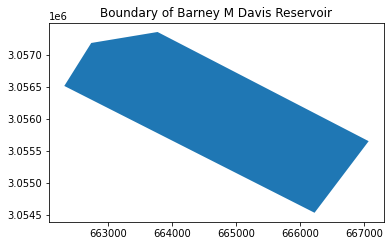

In [137]:
# Reproject data to CRS of raster data
area_of_interest=polys[polys['Name']==reservoir_name]['geometry']
landsat_crs=check_crs(tif_file_paths[0])
crop_boundary_chng_crs = area_of_interest.to_crs(landsat_crs)
crop_boundary_chng_crs.plot()
plt.title('Boundary of '+reservoir_name)
plt.show()

In [51]:
landsat_raw_data = process_bands(tif_file_paths[:-1], crop_layer=crop_boundary_chng_crs,stack=True)
landsat_raw_data 

Data is getting stacked.


<xarray.DataArray (band: 2, y: 95, x: 160)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * x            (x) float64 6.623e+05 6.623e+05 ... 6.67e+05 6.671e+05
  * y            (y) float64 3.057e+06 3.057e+06 ... 3.055e+06 3.055e+06
  * band         (band) int64 1 2
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [104]:
landsat_qa = open_clean_band(tif_file_paths[2],crop_boundary_chng_crs)

high_cloud_confidence = em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"]
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]

all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Mask the data using the pixel QA layer
cloud_mask = landsat_qa.isin(all_masked_values)
landsat_without_cloud = landsat_raw_data.where(~cloud_mask)

# Calculating NDWI and labelling water as 1
ndwi_landsat=(landsat_without_cloud[0]-landsat_without_cloud[1])/(landsat_without_cloud[0]+landsat_without_cloud[1])
water_landsat=ndwi.where(~(ndwi_landsat.values>0),1)

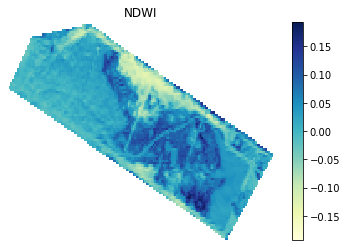

In [148]:
# Plot the data
f, ax=plt.subplots()
ndwi_landsat.plot.imshow(ax=ax,
                  cmap="YlGnBu")
ax.set_axis_off()
ax.set_title("NDWI")
plt.show()

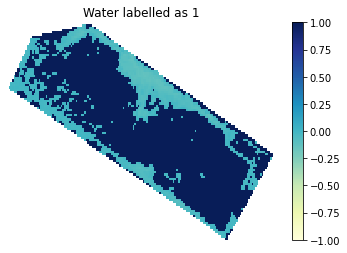

In [150]:
# Plot the data
f, ax=plt.subplots()
water_landsat.plot.imshow(ax=ax,
                  cmap="YlGnBu")
ax.set_axis_off()
ax.set_title("Water labelled as 1")
plt.show()